In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math

In [2]:
POPULATION_SIZE = 1000
INITIAL_SICK = 1
INITIAL_HEALTHY = POPULATION_SIZE - INITIAL_SICK

SICK_COLOR = (1, 0, 0)
HEALTHY_COLOR = (0, 1, 0)
RECOVERED_COLOR = (0.7, 0, 0.7)

In [3]:
class Person:
    x: float
    y: float
    sick: bool
    recovered: bool
    susceptibility: float
    color: tuple[int, int, int]

    def __init__(self, **kwargs):
        self.x = random.random()
        self.y = random.random()
        self.sick = False
        self.recovered = False
        self.color = HEALTHY_COLOR
        self.mobility = random.random()
        self.susceptibility = random.random()
        self.recovered_susceptibility = 0
        for key, value in kwargs.items():
            setattr(self, key, value)

    def get_sick(self):
        """ Become sick, update corresponding fields. """
        self.sick = True
        self.color = SICK_COLOR
        self.susceptibility = 0

    def get_color(self):
        """ Get representation of a person health as a corresponding color. """
        return self.color

    def get_position(self) -> tuple[float, float]:
        """ Return current person location. """
        return self.x, self.y

    def recover(self):
        """ Recover from sickness, update corresponding fields. """
        self.sick = False
        self.recovered = True
        self.color = RECOVERED_COLOR
        self.susceptibility = self.recovered_susceptibility

    def move(self):
        """ Move from previous position to a new one. """
        move_x, move_y = self.get_move_values()
        self.x += move_x
        self.y += move_y
        self.apply_boundary_conditions()

    def apply_boundary_conditions(self):
        """ Check if person did not leave the space of the simulation, if so modifies its position. """
        if self.x > 1:
            self.x -= 1
        if self.x < 0:
            self.x += 1
        if self.y > 1:
            self.y -= 1
        if self.y < 0:
            self.y += 1

    def get_distance_to_travel(self) -> float:
        """ Get distance person will move at the given time step. """
        return random.random() * self.mobility

    @staticmethod
    def get_move_coefficients():
        """ Generate direction in which person will be moved at the given time step. """
        angle = math.radians(random.random() * 360)
        return math.cos(angle), math.sin(angle)

    def get_move_values(self):
        distance_to_move = self.get_distance_to_travel()
        x_coefficient, y_coefficient = self.get_move_coefficients()
        return distance_to_move * x_coefficient, distance_to_move * y_coefficient


In [14]:
class Simulation:
    color = tuple[float, float, float]
    population_time_step = tuple[float, float, color]

    population_size: int
    initial_sick: int
    population: list[Person]
    frames: list[population_time_step]

    fig: plt.Figure
    ax: plt.Axes
    animation: animation

    def __init__(self, population_size: int, initial_sick: int = 1):
        self.frames = []
        self.initial_sick = initial_sick
        self.population_size = population_size
        self.population = [Person() for x in range(population_size)]
        self.save_frame(*self.get_population_position())
        for idx in range(initial_sick):
            self.population[idx].get_sick()
        self.init_fig()

    def get_population_position(self) -> population_time_step:
        """ Get current x, y coordinates of each person and appropriate color depending on the health status. """
        population_description = ((*person.get_position(), person.get_color()) for person in
                                  self.population)
        return tuple(zip(*population_description))

    def save_frame(self, x: list[float], y: list[float], c: list[color]) -> None:
        """ Adds a single frame representing current state of the simulation to the record. """
        self.frames.append((x, y, c))

    def get_frame(self, frame_index: int = -1) -> population_time_step:
        """ Get selected frame of the simulation. """
        if frame_index not in range(len(self.frames)):
            frame_index = -1
        return self.frames[frame_index]

    def draw(self):
        """ Draw last frame as 2d scatter plot. """
        position_x, position_y, colors = self.get_frame()
        fig = self.ax.scatter(position_x, position_y, c=colors)
#         self.fig.show()

    def update(self, frame_index: int):
        position_x, position_y, colors = self.get_frame(frame_index)
        fig = self.ax.scatter(position_x, position_y, c=colors)

    def init_fig(self):
        self.fig = plt.figure(figsize=(7, 7))
        self.ax = self.fig.add_axes([0, 0, 1, 1], frameon=True)
#         self.ax.set_xlim(0, 1)
#         self.ax.set_xticks([])
#         self.ax.set_ylim(0, 1)
#         self.ax.set_yticks([])

#     def get_animation(self, steps: int):
#         if self.animations is None:
#             for step in range(steps):
                
#         self.animation = animation.FuncAnimation(self.fig, self.update, steps, interval=10)
#         plt.show()


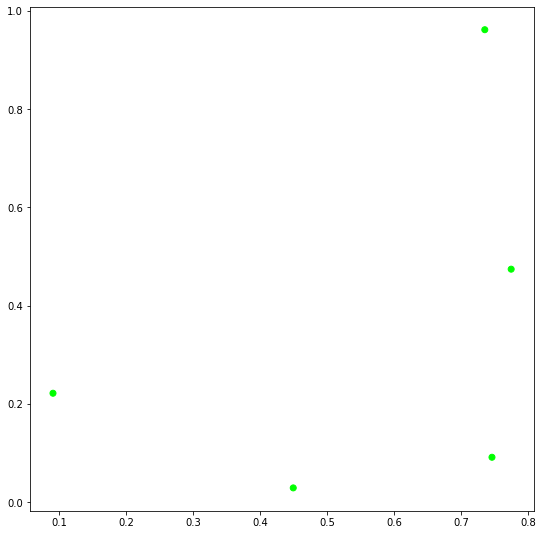

In [15]:
# %matplotlib widget
simulation = Simulation(5)
simulation.draw()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
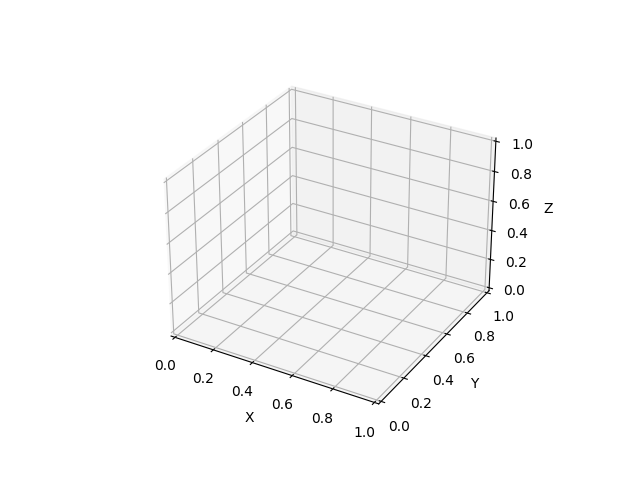

In [22]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)


def random_walk(num_steps, max_step=0.05):
    """Return a 3D random walk as (num_steps, 3) array."""
    start_pos = np.random.random(3)
    steps = np.random.uniform(-max_step, max_step, size=(num_steps, 3))
    walk = start_pos + np.cumsum(steps, axis=0)
    return walk


def update_lines(num, walks, lines):
    for line, walk in zip(lines, walks):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(walk[:num, :2].T)
        line.set_3d_properties(walk[:num, 2])
    return lines


# Data: 40 random walks as (num_steps, 3) arrays
num_steps = 30
walks = [random_walk(num_steps) for index in range(40)]

# Attaching 3D axis to the figure
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Create lines initially without data
lines = [ax.plot([], [], [])[0] for _ in walks]

# Setting the axes properties
ax.set(xlim3d=(0, 1), xlabel='X')
ax.set(ylim3d=(0, 1), ylabel='Y')
ax.set(zlim3d=(0, 1), zlabel='Z')

# Creating the Animation object
ani = animation.FuncAnimation(
    fig, update_lines, num_steps, fargs=(walks, lines), interval=100)

plt.show()